# Exploratory Data Analysis for the King County Housing Market

Author: Sebastian Nagel

## How to run this notebook

To setup your python environment and download the necessary packages, please run the following commands in your CLI of choice:

```sh
pyenv local 3.9.8
python -m venv .venv
source .venv/bin/activate
pip install --upgrade pip
pip install -r requirements.txt
```

## Aim and scope of this project

1. Explore the dataset and come up with hypotheses
1. Generate at least 3 general insights, one geographical
1. Come up with at least 3 recommendations for the stakeholder (see below)

Fictive stakeholder:
|Name|Stakeholder|Characteristics|
|-|-|-|
| Larry Sanders       | Buyer       | Waterfront , limited budget, nice & isolated but central neighborhood without kids (but got some of his own, just doesn't his kids to play with other 

## Python imports

Packages and modules needed can be installed _via_ CLI using 

```pip install -r requirements.txt```

In [39]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import folium


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Dataset

Loading the data into a pandas DataFrame (it's not too big. roughly 22k rows x 21 columns)

In [40]:
fp = 'data/kc_house_data.csv'
df_main = pd.read_csv(fp)

### Data quality and bias

#### Quality
|Characteristic|Details|Pass|
|:-|:-|:-:|
|Reliable|Dataset generated by the government of King County|✔️|
|Original|Dataset downloaded from the government of King County|✔️|
|Comprehensive|Dataset is missing some entries|❌|
|Current|For the sake of this task, the data is considered to be current. Data is from 2014/2015|✔️/❌|
|Cited|Dataset has been used many times and is prominently featured on kaggle.com|✔️|

#### Bias
Since this dataset is simply a representation of the King County housing market, there is arguably no bias.
However, the data collection process is unknown to the author.

## Data cleaning

### Issues

First, the non-null counts and data types are checked for consistency. This gives insights into the dataset's structure and integrity.

Here, null values are found in columns
- waterfront
- view
- yr_renovated

Also, the datatypes for the following columns need to be reviewed and if necessary changed:
- date
- bathrooms
- floors
- waterfront
- view
- sqft_basement
- yr_renovated

In [41]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Fixing data types and missing/wrong data of several columns

After researching the domain, the follwing cleaning is not necessary
- Bathrooms: can be "half a bathroom": then only including e.g. a toilet and a sink --> dtype float is okay!
- Floors: there are "half floors" (basically double-height appartments with an open upper floor) --> dtype float is okay!
- View: cannot simply replace nan with 0, thus will leave as it is.

The following columns will be fixed:
- Date: will be typed as datetime object
- sqft_basement: will be typed as numeric (float), invalid numbers set to nan
- yr_renovated: will be typed as datetime, invalid values set to nan

The following columns should be fixed, but I did not find a way:
- Waterfront: nan values can be both, 0 and 1


In [42]:
# type date column as datetime object
df_main['date'] = pd.to_datetime(df_main['date'], format="%m/%d/%Y")
# type sqft_basement as numeric (will be float, because has NaNs)
df_main['sqft_basement'] = pd.to_numeric(df_main['sqft_basement'], errors='coerce')
# replace 0 with np.nan in yr_renovated (there are only few places renovated)
df_main['yr_renovated'] = pd.to_numeric(df_main['yr_renovated'], errors='coerce')
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21143 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

Map, showing all listings with np.nan for waterfront:

In [43]:
df_water = df_main[df_main['waterfront'] != 1]
df_water = df_water[df_water['waterfront'] != 0]
fig = px.scatter_mapbox(df_water[df_water['sqft_basement'] != 0], lat="lat", lon="long", color_discrete_sequence=["blue"], zoom=8.8, height=600, width=600, opacity=1)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Hypotheses

1. Newer houses are more expensive than comparable older houses (or: the more recent a house was build, the more expensive it is)
    1. Recently renovated houses are more expensive than non-renovated houses of the same build year
1. On average housing in the city center of seattle is smaller (less rooms/sqft) than in the outskirts
1. Housing has generally gotten more expensive in 2015 compared with 2014
1. Houseprices are subject to seasons

In [44]:
df_main.head(10)

id       date       price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.000         3      1.000         1180   
1  6414100192 2014-12-09  538000.000         3      2.250         2570   
2  5631500400 2015-02-25  180000.000         2      1.000          770   
3  2487200875 2014-12-09  604000.000         4      3.000         1960   
4  1954400510 2015-02-18  510000.000         3      2.000         1680   
5  7237550310 2014-05-12 1230000.000         4      4.500         5420   
6  1321400060 2014-06-27  257500.000         3      2.250         1715   
7  2008000270 2015-01-15  291850.000         3      1.500         1060   
8  2414600126 2015-04-15  229500.000         3      1.000         1780   
9  3793500160 2015-03-12  323000.000         3      2.500         1890   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650   1.000         NaN 0.000  ...      7        1180          0.000   
1      7242   2.000       0.000 0.000  ...      7        2170        400.000   
2     10000   1.000       0.000 0.000  ...      6         770          0.000   
3      5000   1.000       0.000 0.000  ...      7        1050        910.000   
4      8080   1.000       0.000 0.000  ...      8        1680          0.000   
5    101930   1.000       0.000 0.000  ...     11        3890       1530.000   
6      6819   2.000       0.000 0.000  ...      7        1715            NaN   
7      9711   1.000       0.000   NaN  ...      7        1060          0.000   
8      7470   1.000       0.000 0.000  ...      7        1050        730.000   
9      6560   2.000       0.000 0.000  ...      7        1890          0.000   

   yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  
0      1955         0.000    98178 47.511 -122.257           1340        5650  
1      1951      1991.000    98125 47.721 -122.319           1690        7639  
2      1933           NaN    98028 47.738 -122.233           2720        8062  
3      1965         0.000    98136 47.521 -122.393           1360        5000  
4      1987         0.000    98074 47.617 -122.045           1800        7503  
5      2001         0.000    98053 47.656 -122.005           4760      101930  
6      1995         0.000    98003 47.310 -122.327           2238        6819  
7      1963         0.000    98198 47.410 -122.315           1650        9711  
8      1960         0.000    98146 47.512 -122.337           1780        8113  
9      2003         0.000    98038 47.368 -122.031           2390        7570  

[10 rows x 21 columns]

Hypothesis 1:

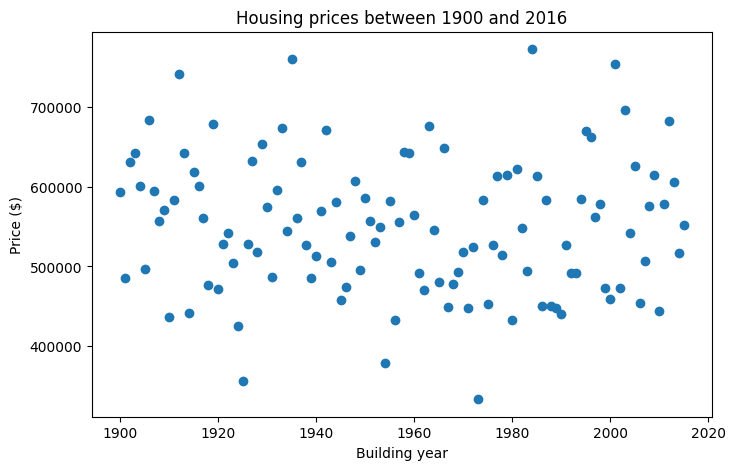

In [45]:
fig, ax = plt.subplots()
ax.scatter(df_main['yr_built'].unique(), df_main.groupby('yr_built')['price'].mean())
ax.set_xlabel('Building year')
ax.set_ylabel('Price ($)')
ax.set_title('Housing prices between 1900 and 2016')
None

Hypothesis 3:

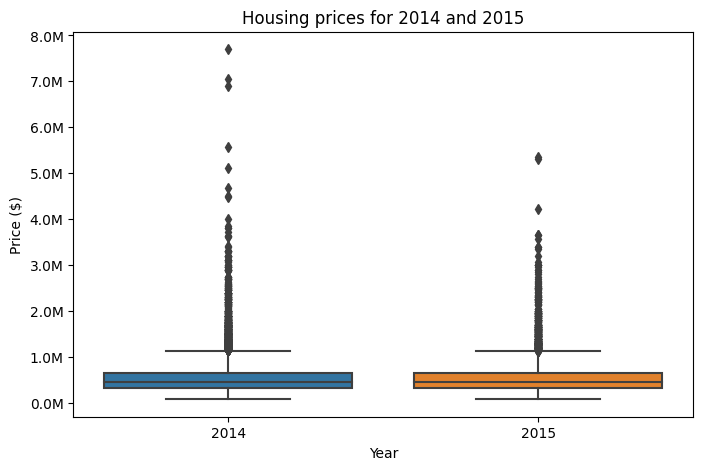

In [46]:
# generate new dataframe
df_prices_by_year = df_main.copy()
# drop everything unnecessary
for c in df_prices_by_year:
    if not c in ['id', 'date', 'price']: 
        df_prices_by_year.drop(c, axis=1, inplace=True)
# formate date column to only show years
df_prices_by_year['date'] = df_prices_by_year['date'].dt.year
# plot the results as boxplots
bp = sns.boxplot(data=df_prices_by_year, x='date', y='price')
bp.set_title('Housing prices for 2014 and 2015')
bp.set_xlabel('Year')
bp.set_ylabel('Price ($)')
xlabels = ['{}'.format(x) + 'M' for x in bp.get_yticks()/1e6]
bp.set_yticklabels(xlabels)
None

In [47]:
fig = px.scatter_mapbox(df_main, lat="lat", lon="long", custom_data =['id', 'price', 'zipcode'],  color=df_main['zipcode'].astype('str'), zoom=8.8, height=600, width=600, opacity=1)
fig.update_traces(
    hovertemplate="<br>".join([
        "ID: %{customdata[0]}",
        "Price: $%{customdata[1]}",
        "ZIP: %{customdata[2]}",
    ])
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Finding recommendations for stakeholder

Stakeholder wants
1. Waterfront
1. Isolated, nice, central neighborhood w/o kids

Stakeholder has
1. Limited budget
1. Kids

Additional information needed:
1. Priorities: are some wishes more important than others?
1. Budget range: can I assume the median for price per neighborhood?
1. How many kids: how many rooms are needed?

Here, I am assuming the stakeholder provided me with the following answers:
1. Has to be waterfront and central.
1. Budget max is $ 1.5M
1. Needs 4 rooms (2 kids)

### Filtering the dataframe according to his wishes

14 houses match his wishes
- waterfront
- max $1.5M
- at least 4 rooms

In [48]:
df_stakeholder = df_main[
                            (df_main['waterfront'] == 1)
                             & (df_main['price'] < 1500000)
                             & (df_main['zipcode'].between(98101, 98200))
                             & (df_main['bedrooms'] >= 4)
                        ].reset_index().drop('index', axis=1)
df_stakeholder

id       date       price  bedrooms  bathrooms  sqft_living  \
0   8069000075 2014-12-29  790000.000         4      1.750         2460   
1    623059016 2014-07-17 1100000.000         4      3.250         3190   
2   7936500190 2014-10-21 1340000.000         4      3.750         2130   
3   7129303045 2015-04-17  949950.000         5      2.500         2340   
4   7567600030 2015-01-27  750000.000         5      1.750         2640   
5   2623039018 2014-10-27  685000.000         4      1.000         1550   
6   9536600010 2014-12-23  520000.000         4      0.750         1960   
7   8073000585 2014-07-15  840500.000         4      2.250         2290   
8   8073000491 2014-12-11  700000.000         4      1.750         1950   
9   7351200050 2014-12-18 1340000.000         4      1.750         2300   
10  6117500460 2014-06-30 1310000.000         4      2.500         2680   
11  6329000190 2014-07-29  750000.000         4      1.750         2520   
12  7110000068 2014-07-03  975000.000         6      2.750         2520   
13  7204200025 2014-10-28 1230000.000         4      2.500         3120   

    sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      10061   1.000       1.000 4.000  ...      7        1410       1050.000   
1      11774   2.000       1.000 4.000  ...      8        2610        580.000   
2      34689   1.500       1.000 4.000  ...      9        2130          0.000   
3       1989   2.000       1.000 4.000  ...      8        2340          0.000   
4      13290   1.000       1.000 4.000  ...      8        1400       1240.000   
5      15239   1.500       1.000 4.000  ...      6        1370        180.000   
6       8277   1.000       1.000 4.000  ...      7        1320        640.000   
7      12174   1.000       1.000 4.000  ...      7        1490        800.000   
8       7139   1.000       1.000 4.000  ...      7        1150        800.000   
9      13342   1.500       1.000 4.000  ...      7        2300          0.000   
10     12215   1.000       1.000 4.000  ...      9        1590       1090.000   
11     21834   1.000       1.000 4.000  ...      8        1420       1100.000   
12     54160   2.000       1.000 4.000  ...      7        2520          0.000   
13     49456   2.000       1.000 4.000  ...      9        2590        530.000   

    yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  
0       1961         0.000    98178 47.511 -122.238           2300       10061  
1       1956      1991.000    98178 47.503 -122.225           2240        8725  
2       1955         0.000    98136 47.549 -122.398           3030       28598  
3       1959           NaN    98118 47.519 -122.257           2200        3230  
4       1954         0.000    98178 47.502 -122.223           2400       11942  
5       1930           NaN    98166 47.450 -122.378           1790       22047  
6       1923      1986.000    98198 47.365 -122.325           1940        8402  
7       1948         0.000    98178 47.511 -122.245           2290        9379  
8       1957         0.000    98178 47.512 -122.248           1600       13122  
9       1934      1958.000    98125 47.731 -122.282           2500       13342  
10      1956         0.000    98166 47.440 -122.353           2960       19964  
11      1960         0.000    98146 47.500 -122.378           1700        8100  
12      1954         0.000    98146 47.497 -122.376           2790       26809  
13      1974      1989.000    98198 47.353 -122.323           2030       32181  

[14 rows x 21 columns]

### Plotting the locations

Out of the 14 houses found, 11 are located nicely close to the center. The top one (ID: 7351200050) and bottom two (IDs: 7204200025 and 9536600010) are excluded for now.

In [49]:
# import the geojson for geographic data on seattle zipcodes
with open('./data/kc_zipcodes.geojson') as f:
    kc_zipcodes_gj = json.load(f)

# extract zipcodes and wanted data from df_main
df_temp = df_main[['zipcode', 'price']].sort_values(by='zipcode').reset_index()
df_temp = df_main.groupby('zipcode')['price'].median().reset_index()

# concat both tables
zipcodes = list()
for f in kc_zipcodes_gj['features']:
    zipcodes.append(f['properties']['ZIP'])
zipcodes = pd.Series(zipcodes, name='kc_zipcodes')
df_temp = pd.concat([zipcodes, df_temp], axis=1).drop('zipcode', axis=1)
#df_temp['price'] = df_temp['price'].fillna(0)
df_temp['kc_zipcodes'] = df_temp['kc_zipcodes'].astype('int')

# draw the map
f = folium.Figure(width=1000, height=500)
m = folium.Map(location=[47.47, -121.7], tiles='openstreetmap', zoom_start=8.5).add_to(f)
cp = folium.Choropleth(
                        geo_data=kc_zipcodes_gj,
                        name='Price',
                        data=df_temp,
                        columns=['kc_zipcodes', 'price'],
                        key_on='properties.ZIP',
                        fill_color='YlOrRd',
                        fill_opacity=0.7,
                        line_opacity=1,
                        line_weight=0.5,
                        legend_name=f'Median house prices by zipcodes',
                    ).add_to(m)

# add markers
for idx in range(0, df_stakeholder.shape[0]):
    folium.Marker([df_stakeholder['lat'][idx], df_stakeholder['long'][idx]],
                   popup=f"ID:&nbsp;{df_stakeholder['id'][idx]}<br>Price:&nbsp;${df_stakeholder['price'][idx]}<br>ZIP:&nbsp;{df_stakeholder['zipcode'][idx]}", 
                   tooltip=f"ID: {df_stakeholder['id'][idx]}").add_to(m)

# adding tooltips
for s in cp.geojson.data['features']:
    s['properties']['median_price'] = df_temp['price'][df_temp['kc_zipcodes'] == s['properties']['ZIP']].values[0]

folium.GeoJsonTooltip(['ZIP', 'median_price']).add_to(cp.geojson)
folium.LayerControl().add_to(m)
m

In [50]:
# removing unwanted houses
df_stakeholder = df_stakeholder[~(df_stakeholder['id'].isin([7351200050, 7204200025, 9536600010]))]
df_stakeholder

id       date       price  bedrooms  bathrooms  sqft_living  \
0   8069000075 2014-12-29  790000.000         4      1.750         2460   
1    623059016 2014-07-17 1100000.000         4      3.250         3190   
2   7936500190 2014-10-21 1340000.000         4      3.750         2130   
3   7129303045 2015-04-17  949950.000         5      2.500         2340   
4   7567600030 2015-01-27  750000.000         5      1.750         2640   
5   2623039018 2014-10-27  685000.000         4      1.000         1550   
7   8073000585 2014-07-15  840500.000         4      2.250         2290   
8   8073000491 2014-12-11  700000.000         4      1.750         1950   
10  6117500460 2014-06-30 1310000.000         4      2.500         2680   
11  6329000190 2014-07-29  750000.000         4      1.750         2520   
12  7110000068 2014-07-03  975000.000         6      2.750         2520   

    sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      10061   1.000       1.000 4.000  ...      7        1410       1050.000   
1      11774   2.000       1.000 4.000  ...      8        2610        580.000   
2      34689   1.500       1.000 4.000  ...      9        2130          0.000   
3       1989   2.000       1.000 4.000  ...      8        2340          0.000   
4      13290   1.000       1.000 4.000  ...      8        1400       1240.000   
5      15239   1.500       1.000 4.000  ...      6        1370        180.000   
7      12174   1.000       1.000 4.000  ...      7        1490        800.000   
8       7139   1.000       1.000 4.000  ...      7        1150        800.000   
10     12215   1.000       1.000 4.000  ...      9        1590       1090.000   
11     21834   1.000       1.000 4.000  ...      8        1420       1100.000   
12     54160   2.000       1.000 4.000  ...      7        2520          0.000   

    yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  
0       1961         0.000    98178 47.511 -122.238           2300       10061  
1       1956      1991.000    98178 47.503 -122.225           2240        8725  
2       1955         0.000    98136 47.549 -122.398           3030       28598  
3       1959           NaN    98118 47.519 -122.257           2200        3230  
4       1954         0.000    98178 47.502 -122.223           2400       11942  
5       1930           NaN    98166 47.450 -122.378           1790       22047  
7       1948         0.000    98178 47.511 -122.245           2290        9379  
8       1957         0.000    98178 47.512 -122.248           1600       13122  
10      1956         0.000    98166 47.440 -122.353           2960       19964  
11      1960         0.000    98146 47.500 -122.378           1700        8100  
12      1954         0.000    98146 47.497 -122.376           2790       26809  

[11 rows x 21 columns]

Now regarding his other wishes:
- isolated, nice neighborhood
- no kids

To be "most isolated", the own lot and that of neighbors should be as big as possible. So let's sort for that:

In [51]:
df_top5 = df_stakeholder.sort_values(by='sqft_lot15', ascending=False).head(5).reset_index().drop('index', axis=1)
df_top5['rank'] = list(range(1, 6))
df_top5

id       date       price  bedrooms  bathrooms  sqft_living  \
0  7936500190 2014-10-21 1340000.000         4      3.750         2130   
1  7110000068 2014-07-03  975000.000         6      2.750         2520   
2  2623039018 2014-10-27  685000.000         4      1.000         1550   
3  6117500460 2014-06-30 1310000.000         4      2.500         2680   
4  8073000491 2014-12-11  700000.000         4      1.750         1950   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0     34689   1.500       1.000 4.000  ...        2130          0.000   
1     54160   2.000       1.000 4.000  ...        2520          0.000   
2     15239   1.500       1.000 4.000  ...        1370        180.000   
3     12215   1.000       1.000 4.000  ...        1590       1090.000   
4      7139   1.000       1.000 4.000  ...        1150        800.000   

   yr_built  yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  \
0      1955         0.000    98136 47.549 -122.398           3030       28598   
1      1954         0.000    98146 47.497 -122.376           2790       26809   
2      1930           NaN    98166 47.450 -122.378           1790       22047   
3      1956         0.000    98166 47.440 -122.353           2960       19964   
4      1957         0.000    98178 47.512 -122.248           1600       13122   

   rank  
0     1  
1     2  
2     3  
3     4  
4     5  

[5 rows x 22 columns]

Let's look at the first five:

In [59]:
fig = px.scatter_mapbox(df_top5, lat="lat", lon="long",
                        custom_data=['rank', 'id', 'price', 'zipcode'], 
                        color=df_top5['zipcode'].astype('str'), 
                        zoom=10, height=600, width=600, opacity=1)

fig.update_traces(hovertemplate="<br>".join(["Rank: %{customdata[0]}",
                                             "ID: %{customdata[1]}",
                                             "Price: $%{customdata[2]}",
                                             "ZIP: %{customdata[3]}",
                                           ]),
                 marker=dict(size=20)
                )

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

How about no kids? Let's plot the school sites around the top 5 recommendations:

In [57]:
# load school sites
df_school_sites = pd.read_csv('./data/seattle_schools.csv')

fig = px.scatter_mapbox(df_school_sites, lat="Y", lon="X",
                        custom_data=['schName', 'esmshs'], 
                        color_discrete_sequence=["blue"], 
                        zoom=10, height=600, width=600, opacity=1)

fig.update_traces(hovertemplate="<br>".join(["Name: %{customdata[0]}",
                                             "Type: %{customdata[1]}",
                                           ]),
                 marker=dict(size=5)
                )

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

All of those locations have schools around them (no data available outside of Seattle!), but IDs 7936500190, 7110000068, and 8073000491 seem to be the furthest away from any schools.

Thus, my final 3 three recommendations for
- nice, central, isolated neighborhood
- 1.5M budget
- Two kids / 4 bedroom apartment

are IDs 7936500190 ($1.34M), 7110000068 ($0.98M), and 8073000491 ($0.70M)

